<a href="https://colab.research.google.com/github/TabassumShaik/Histopatholgy/blob/main/xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle


     |████████████████████████████████| 61kB 7.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=7386d89cae16184ae71f257d56c7a0b201d016ad1282d20055c51dabdda38d40
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"tabassumshaik","key":"d0ea648faf2989f78df4bd7cfcf3a28f"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [02:19<00:00, 46.7MB/s]
100% 6.31G/6.31G [02:19<00:00, 48.7MB/s]


In [7]:
%matplotlib inline

In [8]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5MB 19.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [9]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [10]:
import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.xception import Xception
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, Concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

In [11]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "histopathologic_cancer_detector.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
ROC_PLOT_FILE = "roc.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"
INPUT_DIR = '/content/sample_data'

In [12]:
SAMPLE_COUNT = 8500
TRAINING_RATIO = 0.9
IMAGE_SIZE = 224
EPOCHS = 30
BATCH_SIZE = 18
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [13]:
import zipfile
with zipfile.ZipFile("/content/histopathologic-cancer-detection.zip","r") as zip_ref:
  zip_ref.extractall("/content/sample_data")

In [14]:
training_dir = "/content/sample_data/train"
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
len(data_frame)

220025

In [15]:
data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[4].split('.')[0])
data_frame['id'].head()

0    28531f8722c4147bc95bcf5f4b91a7d19415c157
1    abe7eac29d236d4b9f857f2a17d312c11175433a
2    e4fe29836cb88dfda84220d9d16ca8da40d040ae
3    c2bc093428e94cbca756ff91fb06293f8c513ecc
4    7f79251e274a2d81d794d105150cf49e55fb770e
Name: id, dtype: object

In [16]:
data_frame.head()

path                                        id
0  /content/sample_data/train/28531f8722c4147bc95...  28531f8722c4147bc95bcf5f4b91a7d19415c157
1  /content/sample_data/train/abe7eac29d236d4b9f8...  abe7eac29d236d4b9f857f2a17d312c11175433a
2  /content/sample_data/train/e4fe29836cb88dfda84...  e4fe29836cb88dfda84220d9d16ca8da40d040ae
3  /content/sample_data/train/c2bc093428e94cbca75...  c2bc093428e94cbca756ff91fb06293f8c513ecc
4  /content/sample_data/train/7f79251e274a2d81d79...  7f79251e274a2d81d794d105150cf49e55fb770e

In [17]:
labels = pd.read_csv('/content/sample_data/train_labels.csv')
labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [18]:
data_frame = data_frame.merge(labels, on = 'id')
data_frame.head(15)

path  ... label
0   /content/sample_data/train/28531f8722c4147bc95...  ...     0
1   /content/sample_data/train/abe7eac29d236d4b9f8...  ...     0
2   /content/sample_data/train/e4fe29836cb88dfda84...  ...     1
3   /content/sample_data/train/c2bc093428e94cbca75...  ...     0
4   /content/sample_data/train/7f79251e274a2d81d79...  ...     0
5   /content/sample_data/train/6fa32a7069d658b82f3...  ...     1
6   /content/sample_data/train/c2d42f8eaab019be879...  ...     0
7   /content/sample_data/train/38b6df87065303379eb...  ...     0
8   /content/sample_data/train/c62ca2fce0e7b774e76...  ...     1
9   /content/sample_data/train/7401f92341282785a65...  ...     1
10  /content/sample_data/train/3c83fc9773a2335ca36...  ...     0
11  /content/sample_data/train/a9171792cd8b2818f81...  ...     0
12  /content/sample_data/train/64f04306f7fba176e82...  ...     1
13  /content/sample_data/train/c3343e4fd84d8a4ec58...  ...     0
14  /content/sample_data/train/f090baff8c69252b855...  ...     1

[15 rows x 3 columns]

In [19]:
negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)
data_frame = pd.concat([negatives, positives]).reset_index()
data_frame = data_frame[['path', 'id', 'label']]

data_frame['image'] = data_frame['path'].map(imread)
data_frame.head()

path  ...                                              image
0  /content/sample_data/train/b45ce0b8d63f5c6acd1...  ...  [[[228, 228, 228], [224, 224, 222], [230, 231,...
1  /content/sample_data/train/b78dfdb6fc588745c42...  ...  [[[243, 245, 242], [235, 237, 234], [251, 253,...
2  /content/sample_data/train/8370b7b5461dd33528c...  ...  [[[206, 162, 185], [168, 125, 152], [95, 56, 8...
3  /content/sample_data/train/0b89978fd2d0b96b8e1...  ...  [[[248, 220, 245], [192, 163, 193], [49, 19, 5...
4  /content/sample_data/train/089e922db586b3da0f2...  ...  [[[196, 82, 178], [227, 113, 209], [211, 97, 1...

[5 rows x 4 columns]

In [20]:
training_path = '/content/training'
validation_path = '/content/validation'

for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)

training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])

data_frame.set_index('id', inplace=True)
data_frame.head()

path  ...                                              image
id                                                                                           ...                                                   
b45ce0b8d63f5c6acd189504ef5cec29519fdec3  /content/sample_data/train/b45ce0b8d63f5c6acd1...  ...  [[[228, 228, 228], [224, 224, 222], [230, 231,...
b78dfdb6fc588745c420655eb7b8ca850e838221  /content/sample_data/train/b78dfdb6fc588745c42...  ...  [[[243, 245, 242], [235, 237, 234], [251, 253,...
8370b7b5461dd33528ca9f61a8302d214858f9f2  /content/sample_data/train/8370b7b5461dd33528c...  ...  [[[206, 162, 185], [168, 125, 152], [95, 56, 8...
0b89978fd2d0b96b8e1061464499c4f8819bdf30  /content/sample_data/train/0b89978fd2d0b96b8e1...  ...  [[[248, 220, 245], [192, 163, 193], [49, 19, 5...
089e922db586b3da0f275433733cc6f3daa8424e  /content/sample_data/train/089e922db586b3da0f2...  ...  [[[196, 82, 178], [227, 113, 209], [211, 97, 1...

[5 rows x 3 columns]

In [21]:


for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(data_frame.loc[image,'label'])
        destination = os.path.join(path, label, file_name)
        if not os.path.exists(destination):
            source = os.path.join(INPUT_DIR , 'train', file_name)
            shutil.copyfile(source, destination)

In [22]:
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=90,
                                             zoom_range=0.2, 
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             shear_range=0.05,
                                             channel_shift_range=0.1)

In [23]:
training_generator = training_data_generator.flow_from_directory(training_path,
                                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                 batch_size=BATCH_SIZE,
                                                                 class_mode='binary')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')

Found 15300 images belonging to 2 classes.
Found 1700 images belonging to 2 classes.


In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

xception = Xception(include_top=False, input_shape=input_shape)  
nas_net = NASNetMobile(include_top=False, input_shape=input_shape)

outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception(inputs)),
                                GlobalAveragePooling2D()(nas_net(inputs))])
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

19996672/19993432 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 7, 7, 2048)   20861480    input_1[0][0]                    
__________________________________________________________________________________________________
NASNet (Functional)             (None, 7, 7, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[0][0]                   
_____________________________

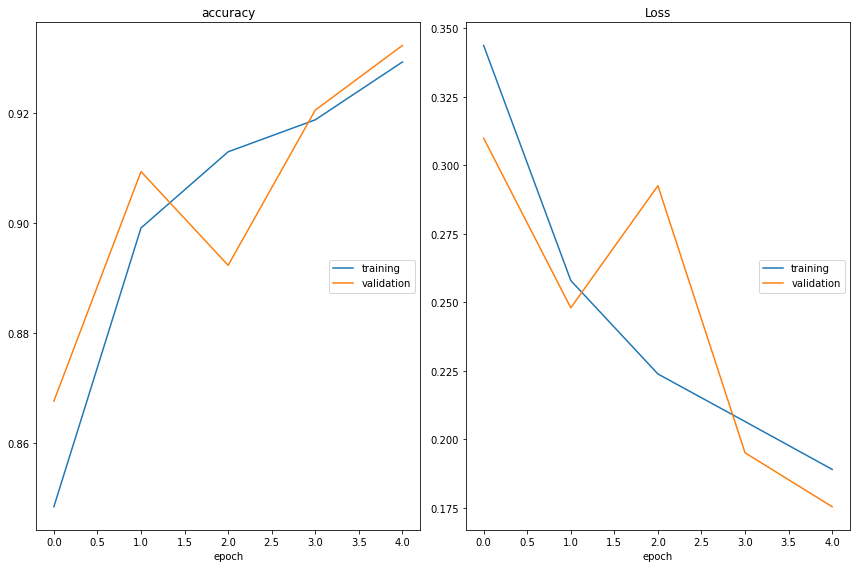

accuracy
	training         	 (min:    0.848, max:    0.929, cur:    0.929)
	validation       	 (min:    0.868, max:    0.932, cur:    0.932)
Loss
	training         	 (min:    0.189, max:    0.344, cur:    0.189)
	validation       	 (min:    0.175, max:    0.310, cur:    0.175)


OSError: ignored

In [25]:
EPOCHS=5
history = model.fit_generator(training_generator,
                              steps_per_epoch=len(training_generator), 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=EPOCHS,
                              verbose=VERBOSITY,
                              callbacks=[PlotLossesKeras(),
                                         ModelCheckpoint(MODEL_FILE,
                                                         monitor='val_acc',
                                                         verbose=VERBOSITY,
                                                         save_best_only=True,
                                                         mode='max'),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=False,
                                                   separator=';')])
model.load_weights(MODEL_FILE)

In [26]:
!pip install h5py pyyaml

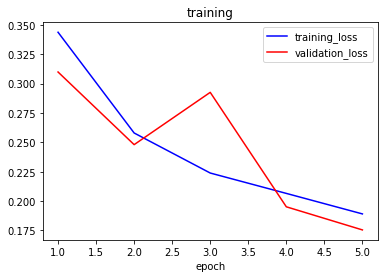

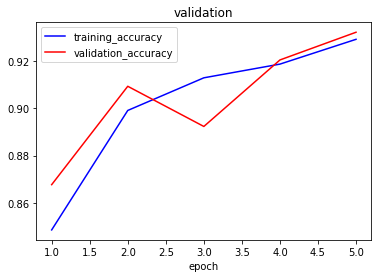

In [29]:
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.show()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.show()

In [31]:
from tensorflow.keras.models import load_model

model.save('histopathologic_cancer_detector.h5')